Using Colab cache for faster access to the 'adult-income-dataset' dataset.


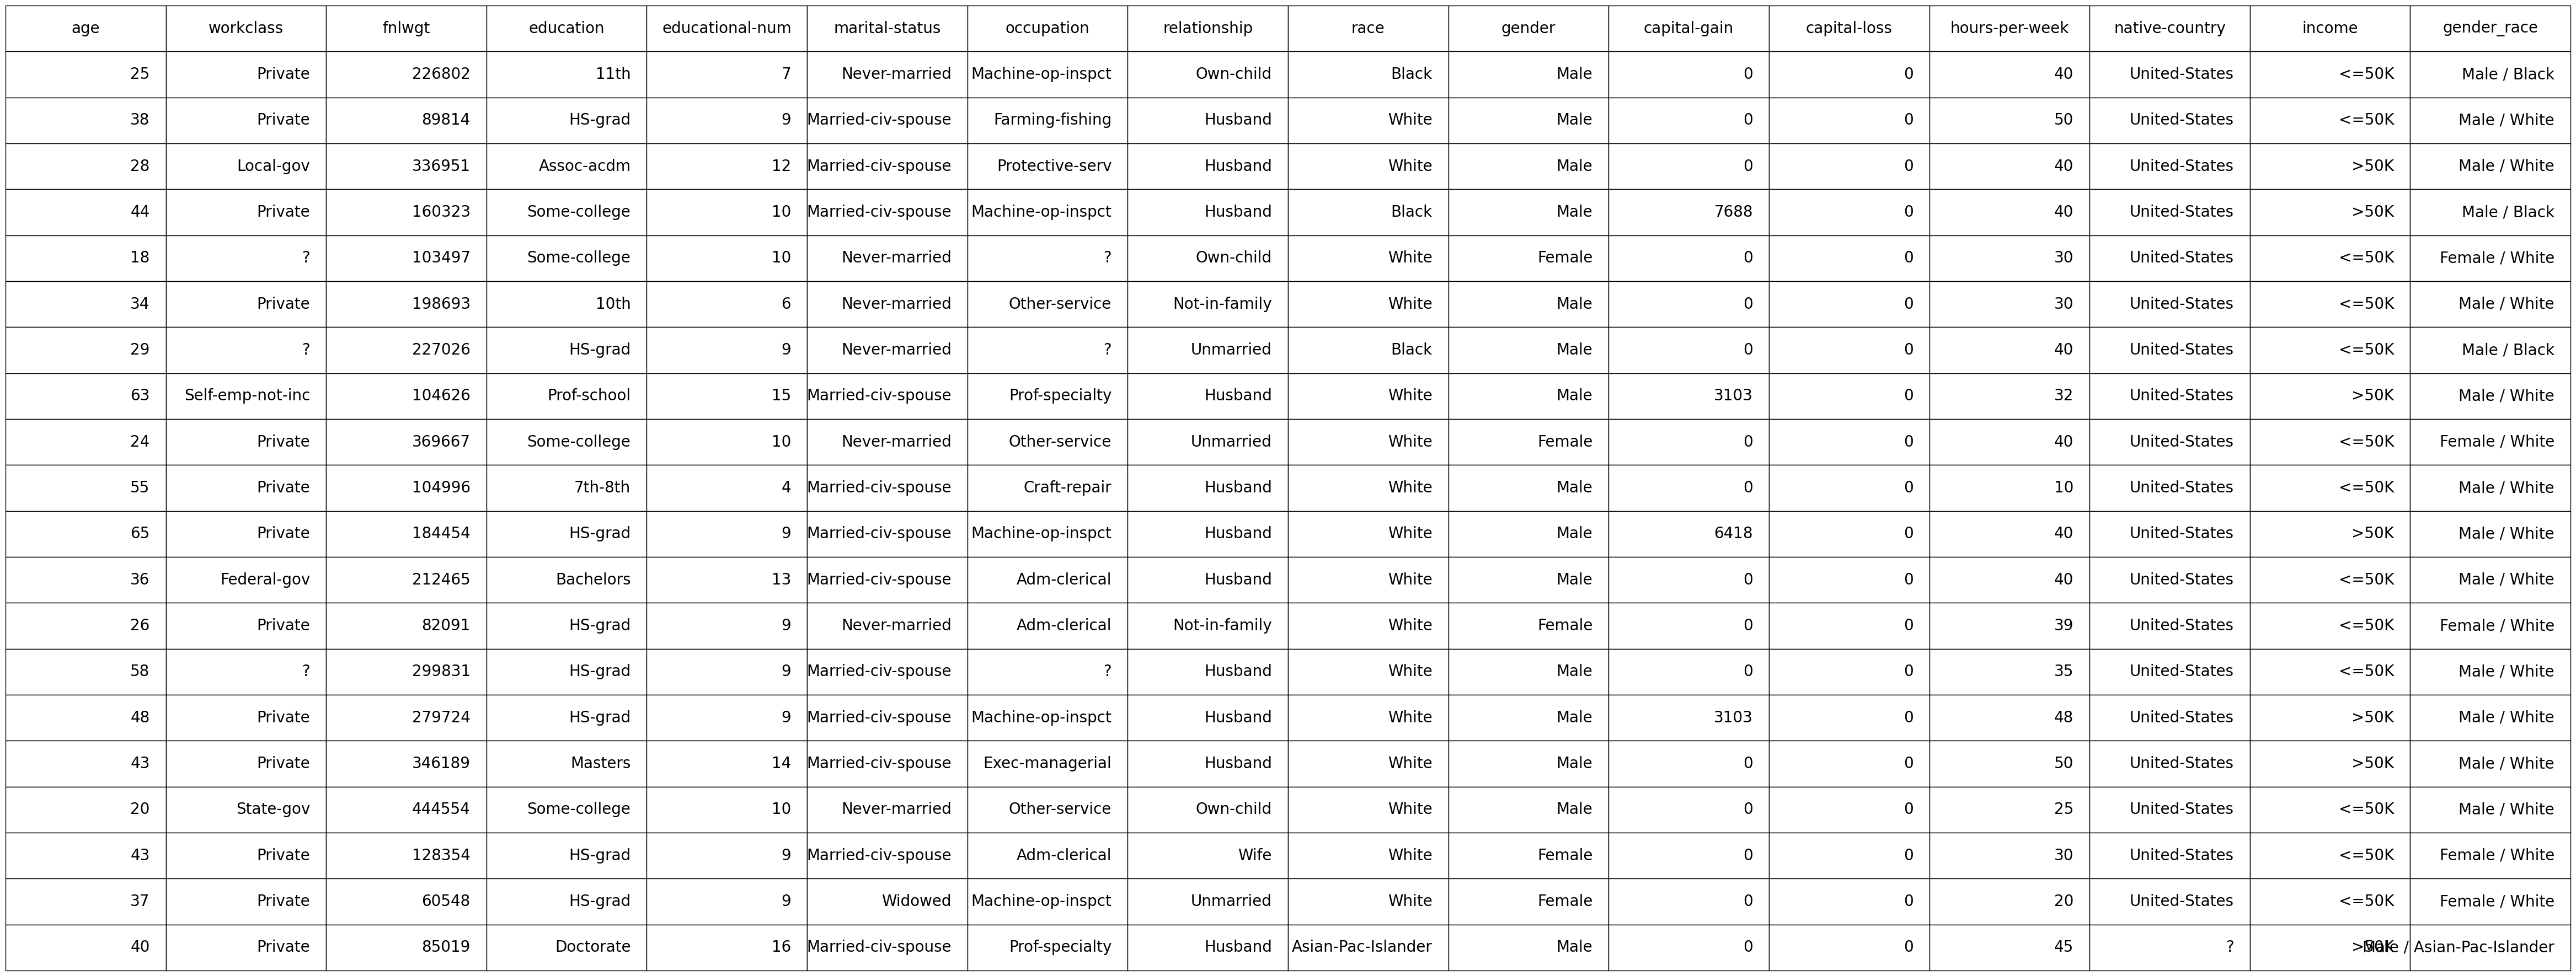

In [1]:
# mais test comment
!pip install -q scikit-learn matplotlib pandas tensorflow
!pip install ucimlrepo


import pandas as pd
import seaborn as sns
import shap
import matplotlib.pyplot as plt

# scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE

#setup kaggle support
import kagglehub
# Download latest version
path = kagglehub.dataset_download("wenruliu/adult-income-dataset")

# Load Data from shap library
X,y = shap.datasets.adult()

data= pd.read_csv("/kaggle/input/adult-income-dataset/adult.csv")
data["gender_race"] = data["gender"] + " / " + data["race"]
small_data = data.head(20)
plt.figure(figsize=(30, 20))
table= plt.table(cellText=small_data.values, colLabels=small_data.columns, loc='center')

table.scale(2, 5)
table.auto_set_font_size(False)
table.set_fontsize(20)
# прибираємо осі, щоб було чисто
plt.axis('off')
#plt.table(small_data)
plt.show()


In [2]:
X = data[['gender_race', 'age', 'education', 'hours-per-week']] #merkmale, die ich untersuche, x-Achse
y = data['income'] #merkmale, die ich untersuche, y-Achse

X = pd.get_dummies(X, drop_first=True)   # One-Hot-Encoding
y = LabelEncoder().fit_transform(y)

# Train-Test-Split
X_train, X_test_b, y_train, y_test_b = train_test_split(X, y, test_size=0.3, random_state=42) #random_state=42 für die reproduzierbare Aufteilung (immer gleich bei erneutem Lauf). funktion teilt in Trainings- und Testdaten auf

In [3]:
model = LogisticRegression(max_iter=5000) #ein logistisches Regressionsmodell
model.fit(X_train, y_train) #hier wird das modell trainiert; Zusammenhang zwischen Eingabe (X_train) und Ziel (y_train).

LogisticRegression(max_iter=5000)

In [4]:
y_pred_b = model.predict(X_test_b) #vorhersage wird generiert, das Modell wird auf testDaten (X_test) angewendet

In [5]:
print("Genauigkeit:", accuracy_score(y_test_b, y_pred_b)) #wie viele Vorhersagen korrekt waren.
print(classification_report(y_test_b, y_pred_b))

Genauigkeit: 0.8021565549716781
              precision    recall  f1-score   support

           0       0.83      0.93      0.88     11233
           1       0.63      0.37      0.47      3420

    accuracy                           0.80     14653
   macro avg       0.73      0.65      0.67     14653
weighted avg       0.78      0.80      0.78     14653





80% Accuracy,
aber das Modell lernt **nichts über die kleinere Klasse.**

In [6]:
feature_names = ["Age", "Workclass",
                 "Education-Num", "Marital Status", "Occupation",
                 "Relationship", "Race", "Sex", "Capital Gain",
                 "Capital Loss", "Hours per week", "Country"]

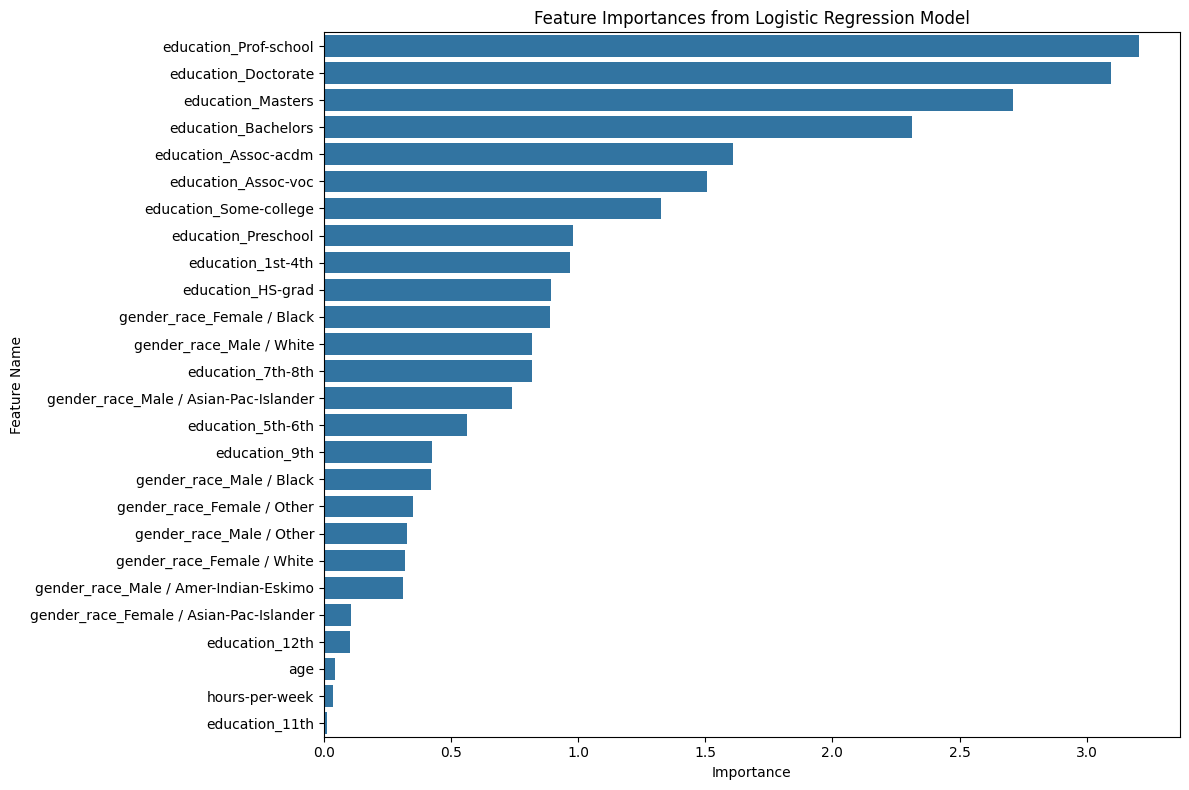

In [7]:
feature_names = X.columns.tolist()

# Create a DataFrame for feature importances
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': abs(model.coef_[0])
})

# Sort features by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plotting the feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importances from Logistic Regression Model')
plt.xlabel('Importance')
plt.ylabel('Feature Name')
plt.tight_layout()
plt.show()

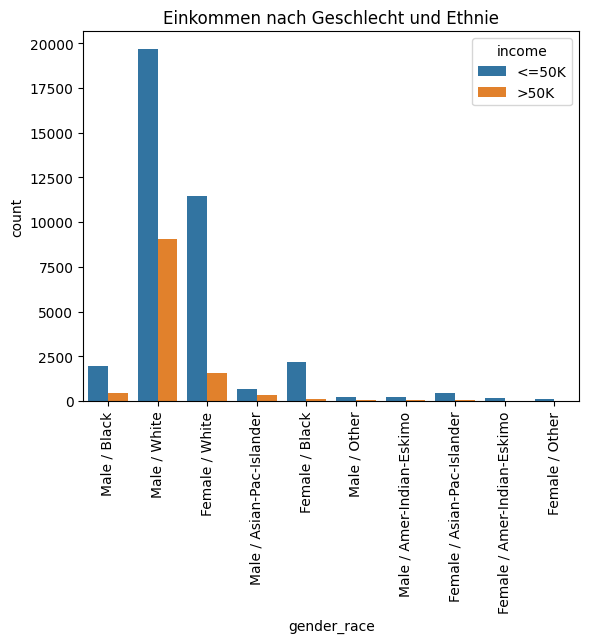

In [8]:
sns.countplot(x='gender_race' , hue='income', data=data) #prüfen, ob es in unseren daten ein Bias gibt.
plt.title("Einkommen nach Geschlecht und Ethnie")
plt.xticks(rotation=90)
plt.show()
#hier merkt man, dass die daten orientieren sich überwiegend auf weiße frauen/männer, andere Geschlechter und Rassen werden nicht berücksichtigt.
#Andere Ethnien	werden unterrepräsentiert, daher werden die vorhersagen ungenauer oder unfair
#Nicht-binäre Geschlechter sind gar nicht vorhanden, diese Gruppe wird komplett ignoriert
# -> potential die daten von weißen menschen zum verhältnis der anderen gruppen anzupassen

obwohl die genauigkeit bei 80% prozent liegt und die wichtigste merkmal education ist, merkt man auf dem histogramm, dass eine bestimmte Gruppe stärker ausgeprägt ist und dadurch entsteht eine Ungleichverteilung, die das Modell lernt. hier geht es um ein Data Bias (structural bias).

In [9]:
bias_table = pd.crosstab(data['race'], data['income'], normalize='index') * 100
print(bias_table)


income                  <=50K       >50K
race                                    
Amer-Indian-Eskimo  88.297872  11.702128
Asian-Pac-Islander  73.074391  26.925609
Black               87.918890  12.081110
Other               87.684729  12.315271
White               74.601312  25.398688


Schon in den Trainingsdaten verdient eine bestimmte Gruppe deutlich häufiger über 50K.
Das Modell lernt also von einem gesellschaftlich voreingenommenen Datensatz.

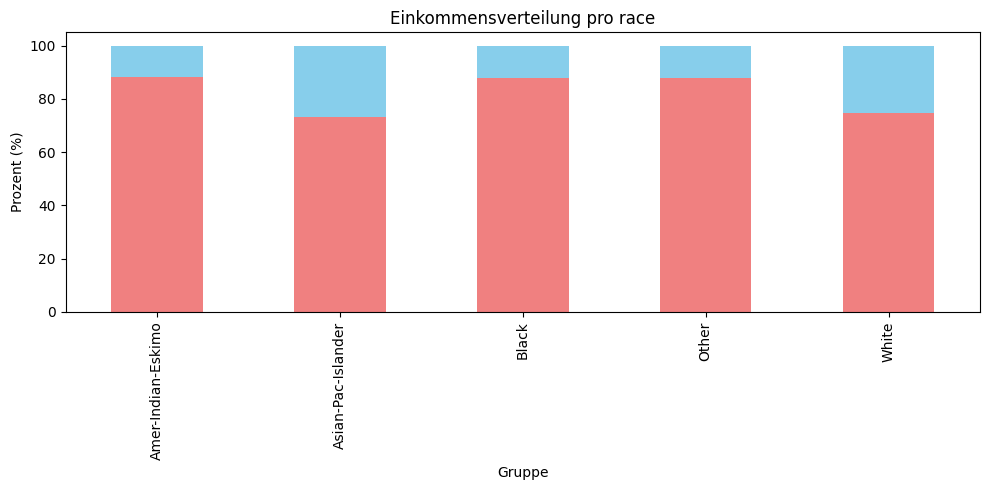

In [10]:
bias_table.plot(kind='bar', stacked=True, figsize=(10,5), color=['lightcoral', 'skyblue'], legend= False)
plt.title('Einkommensverteilung pro race')
plt.ylabel('Prozent (%)')
plt.xlabel('Gruppe')

plt.xticks(rotation=90)
plt.tight_layout()
plt.show()   #🟦 = Anteil >50K
             #🟥 = Anteil <=50K

Das Modell prognostiziert für weiße und "Asian-Pac-Islander" Männer deutlich häufiger ein hohes Einkommen.
Damit übernimmt es den Bias aus den Trainingsdaten und verstärkt ihn ggf. weiter.

In [11]:
data.groupby(['race', 'income']).size().unstack() #hier wird der datensatz nach den spalten income un race gruppiert.


income,<=50K,>50K
race,,
Amer-Indian-Eskimo,415,55
Asian-Pac-Islander,1110,409
Black,4119,566
Other,356,50
White,31155,10607


In [12]:
from imblearn.over_sampling import RandomOverSampler
import pandas as pd

# die kategorie race anpassen
y = data['race']

# andere kategorien vleiben ??
X = data.drop(columns=['race'])

# Random Oversampling
ros = RandomOverSampler(random_state=42)
X_over, y_over = ros.fit_resample(X, y)

# neue daten in DataFrame packen
df_over = pd.DataFrame(X_over, columns=X.columns)
df_over['race'] = y_over

# 5️⃣ Перевіряємо
print(df_over['race'].value_counts())


race
Black                 41762
White                 41762
Asian-Pac-Islander    41762
Other                 41762
Amer-Indian-Eskimo    41762
Name: count, dtype: int64


In [13]:
X = df_over[['gender_race', 'age', 'education', 'hours-per-week']] #merkmale, die ich untersuche, x-Achse
y = df_over['income'] #merkmale, die ich untersuche, y-Achse

X = pd.get_dummies(X, drop_first=True)   # One-Hot-Encoding
y = LabelEncoder().fit_transform(y)

# Train-Test-Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

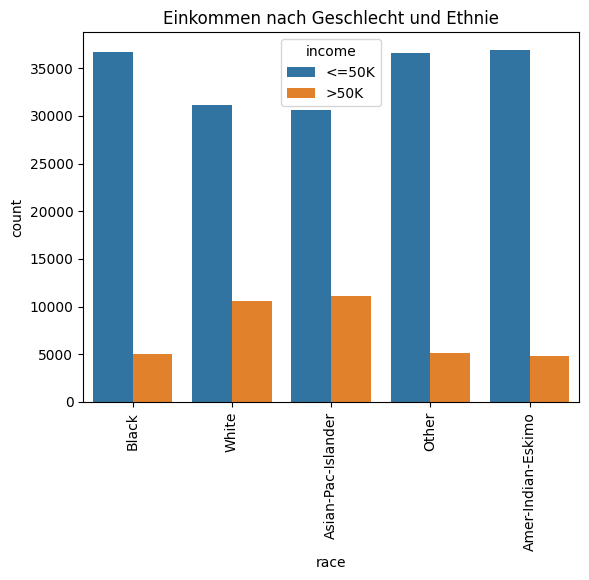

In [14]:
sns.countplot(x='race' , hue='income', data=df_over) #prüfen, ob es in unseren daten ein Bias gibt.
plt.title("Einkommen nach Geschlecht und Ethnie")
plt.xticks(rotation=90)
plt.show()

In [15]:
X = df_over[['gender_race', 'age', 'education', 'hours-per-week']] #merkmale, die ich untersuche, x-Achse
y = df_over['income'] #merkmale, die ich untersuche, y-Achse

X = pd.get_dummies(X, drop_first=True)   # One-Hot-Encoding
y = LabelEncoder().fit_transform(y)

# Train-Test-Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [16]:
model2 = LogisticRegression(max_iter=5000, class_weight='balanced') #ein logistisches Regressionsmodell
model2.fit(X_train, y_train)


LogisticRegression(class_weight='balanced', max_iter=5000)

Ich habe außerdem ein Ungleichgewicht in der Prediction für income ≤ 50K und income > 50K entdeckt. Da die Gruppe income > 50K deutlich kleiner ist, ist die Vorhersage für diese Klasse ebenfalls unfair – Personen mit einem Einkommen über 50K werden schlechter erkannt.
Mit class_weight='balanced' lernt das Modell, Personen mit einem Einkommen über 50K deutlich besser zu erkennen (siehe ganz unten den Recall für beide Modelle: 0.37 → 0.75). Dadurch wurde die Benachteiligung der Minoritätsklasse reduziert.

In [17]:
y_pred = model2.predict(X_test)

In [18]:
print("Genauigkeit:", accuracy_score(y_test, y_pred)) #wie viele Vorhersagen korrekt waren.
print(classification_report(y_test, y_pred))

Genauigkeit: 0.7480644285873921
              precision    recall  f1-score   support

           0       0.93      0.75      0.83     51532
           1       0.39      0.75      0.51     11111

    accuracy                           0.75     62643
   macro avg       0.66      0.75      0.67     62643
weighted avg       0.84      0.75      0.77     62643



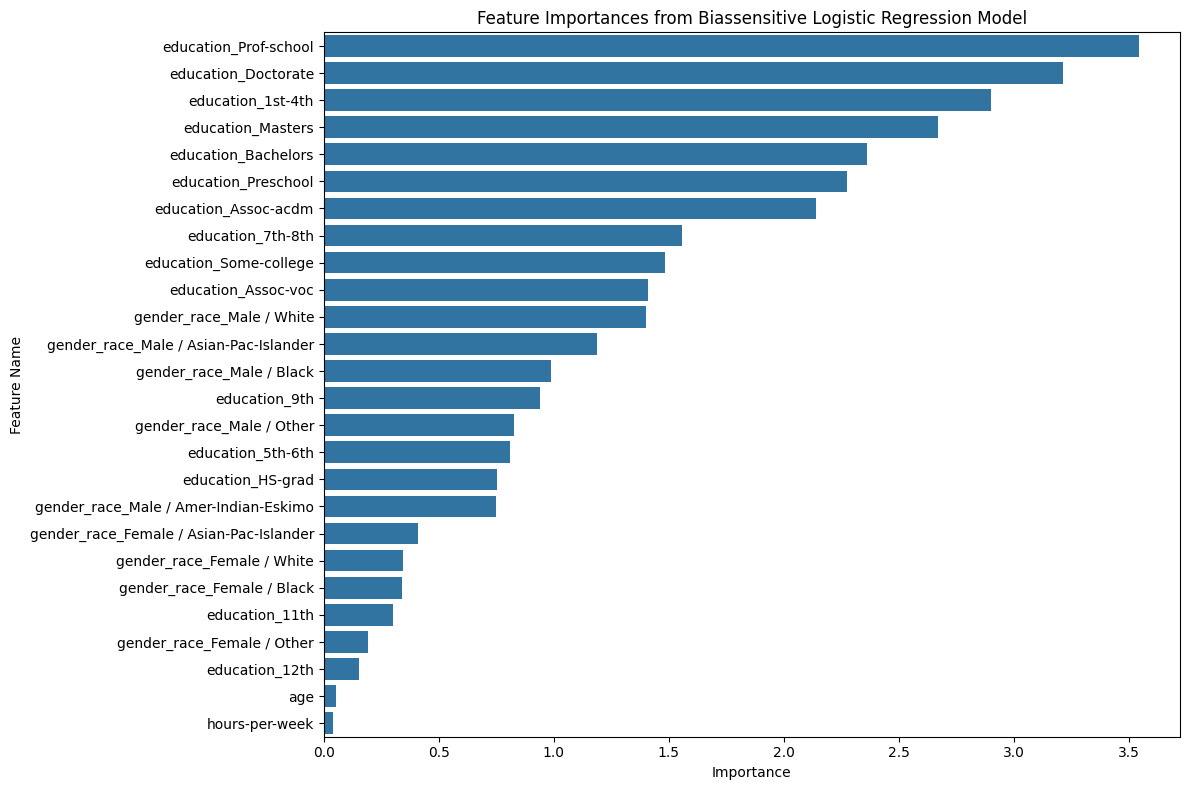

In [19]:
#Nochmal den Feature Importance Graph

feature_names = X.columns.tolist()

# Create a DataFrame for feature importances
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': abs(model2.coef_[0])
})

# Sort features by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plotting the feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importances from Biassensitive Logistic Regression Model')
plt.xlabel('Importance')
plt.ylabel('Feature Name')
plt.tight_layout()
plt.show()

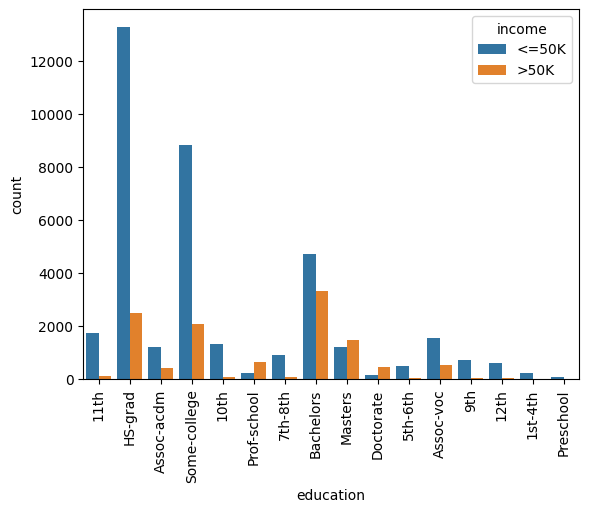

In [20]:
sns.countplot(x='education' , hue='income', data=data) #prüfe, ob es weitere Abhägigkeiten in Daten gibt
plt.xticks(rotation=90)
plt.show()

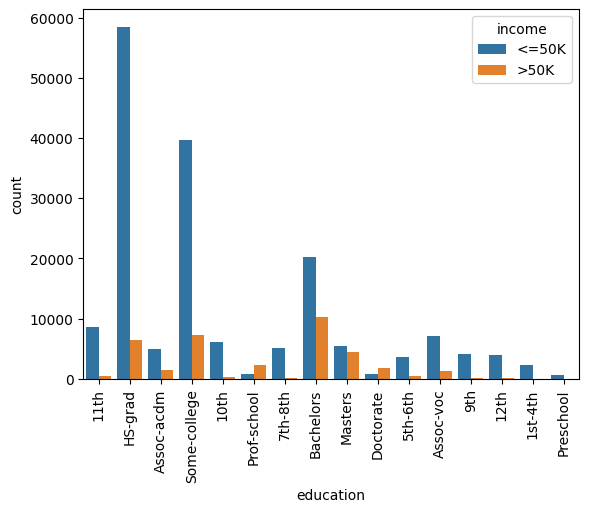

In [21]:
sns.countplot(x='education' , hue='income', data=df_over) #prüfe, ob es weitere Abhägigkeiten in Daten gibt
plt.xticks(rotation=90)
plt.show()

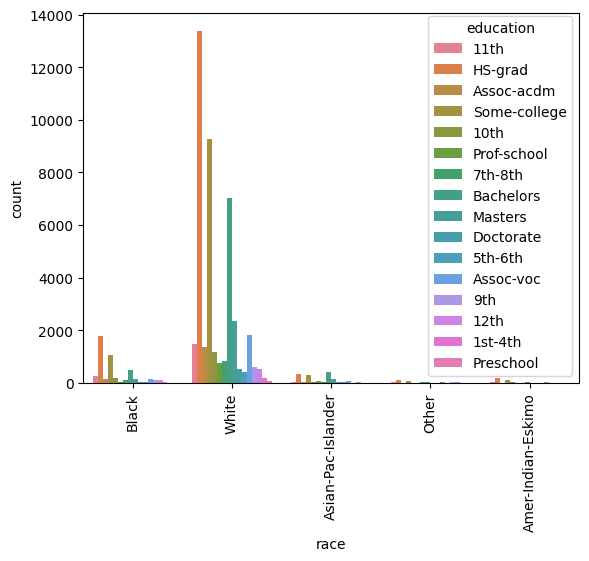

In [22]:
sns.countplot(x='race' , hue='education', data=data) #prüfe, ob es weitere Abhägigkeiten in Daten gibt
plt.xticks(rotation=90)
plt.show()

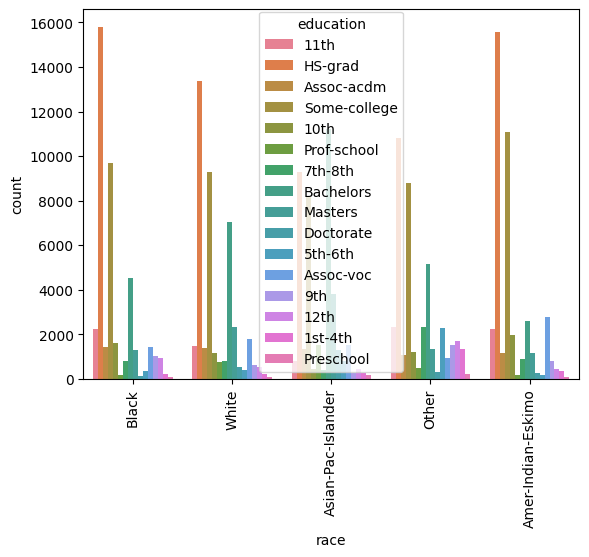

In [23]:
sns.countplot(x='race' , hue='education', data=df_over) #prüfe, ob es weitere Abhägigkeiten in Daten gibt
plt.xticks(rotation=90)
plt.show()

In [24]:


print("Standardmodell: ")
print("Genauigkeit:", accuracy_score(y_test_b, y_pred_b))
pred_before = model.predict(X_test_b)
print(classification_report(y_test_b, pred_before))

print("\n Bias-sensitives Modell: ")
print("Genauigkeit:", accuracy_score(y_test, y_pred))
pred_after = model2.predict(X_test)
print(classification_report(y_test, pred_after))


Standardmodell: 
Genauigkeit: 0.8021565549716781
              precision    recall  f1-score   support

           0       0.83      0.93      0.88     11233
           1       0.63      0.37      0.47      3420

    accuracy                           0.80     14653
   macro avg       0.73      0.65      0.67     14653
weighted avg       0.78      0.80      0.78     14653


 Bias-sensitives Modell: 
Genauigkeit: 0.7480644285873921
              precision    recall  f1-score   support

           0       0.93      0.75      0.83     51532
           1       0.39      0.75      0.51     11111

    accuracy                           0.75     62643
   macro avg       0.66      0.75      0.67     62643
weighted avg       0.84      0.75      0.77     62643



Die accuracy ist im Vergleich zum Standardmodell gesunken. Dafür haben wir unser Ziel erreicht den  niedriegen Recall 1 Value auszugleichen.